# Transfer Learning in Global Warming Sentiment Tweets

The purpose of this execise is to demonstrate the effectiveness of transfer learning in natural language processing (NLP) applications. 

**Concept/Approach**

This notebook focuses on the so-called Universal Language Model Fine-tuning (ULMFiT) introduced by Jeremy Howard and Sebastian Ruder [[1](https://arxiv.org/abs/1801.06146)]. The ULMFiT model consists of three main stages in the building a language model (LM):

1. **General-domain LM  pre-training**: Similar to the ImageNet database used in computer vision, the idea is to pre-train a large corpus of text. The ULMFiT has a pre-trained model called the `Wikitext-103` where more than 20,000 Wikipedia articles was trained on. This is alreadly included in the `fastai.text` API, thus, it is not necessary to carry out this step.

2. **LM fine-tuning**: Because the target data (typically) comes from a different distribution from the general-domain, it is necessary to fine-tune the LM to adapt to the idosyncrasies of the target data. Howard and Ruder suggested *discriminative fine-tuning* and *slanted triangular learning rates* for fine-tuning the LM. These techniques are available in `fastai` and are described in [[1](https://arxiv.org/abs/1801.06146)].

3. **Classifier fine-tuning**: Using the updated weights from the previous step, a classifier
can be fine-tuned. Howard and Ruder suggested a few techniques which include *concat pooling* and *gradual unfreezing*. The latter in particular is used in this demonstration. Again, the `fastai` framework allows one to perform this technique.

For this demonstration, the Twitter data on people's belief on global warming/climate is used. Note that the sentiment of the tweets are based on the contributors evaluation of the tweets.

Data source: [Figure-Eight](https://www.figure-eight.com/data-for-everyone/)

**Reference**

[1] J. Howard and S. Ruder. 2018.*Universal Language Model Fine-tuning for Text Classification*. [arXiv:1801.06146](https://arxiv.org/abs/1801.06146).



In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
sns.set()
sns.set_style({'legend.frameon':True})

In [2]:
import fastai
from fastai import *
from fastai.text import *

In [3]:
import torch
print("CUDA available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch ver.: ", torch.__version__)
print("fastai ver.: ", fastai.__version__)

CUDA available
PyTorch ver.:  1.1.0
fastai ver.:  1.0.34


## Exploratory analysis

Import data as pandas dataframe. An encoding on the data appears necessary.

In [4]:
df = pd.read_csv('tweet_data.csv', encoding='latin-1')
df.head(15)

,tweet,existence,existence.confidence
0,Global warming report urges governments to act...,Yes,1.0000
1,Fighting poverty and global warming in Africa ...,Yes,1.0000
2,Carbon offsets: How a Vatican forest failed to...,Yes,0.8786
3,Carbon offsets: How a Vatican forest failed to...,Yes,1.0000
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,Yes,0.8087
5,RT @sejorg: RT @JaymiHeimbuch: Ocean Saltiness...,Yes,1.0000
6,Global warming evidence all around us|A messag...,Yes,1.0000
7,Migratory Birds' New Climate Change Strategy: ...,Yes,1.0000
8,Southern Africa: Competing for Limpopo Water: ...,Yes,1.0000
9,"Global warming to impact wheat, rice productio...",Yes,1.0000


In [5]:
df['tweet'][5]

'RT @sejorg: RT @JaymiHeimbuch: Ocean Saltiness Shows Global Warming Is Intensifying Our Water Cycle [link]'

In [6]:
df.tail()

,tweet,existence,existence.confidence
6085,"@bloodless_coup ""The phrase 'global warming' s...",Y,1.0000
6086,Virginia to Investigate Global Warming Scienti...,NaN,1.0000
6087,Global warming you tube parody you will enjoy ...,N,0.6411
6088,One-Eyed Golfer: Don't dare tell me about glob...,N,1.0000
6089,man made global warming a hair brained theory ...,N,1.0000


**Observations**: For this exercise, the `existence.confidence` column is dropped. Also note that there are some responses with 'Y' and 'N' under the `existence` column rather than 'Yes' and 'No', respectively. Those values will be converted to 'Yes' and 'No'. The NaN values under the `existence` column correspond to ambiguous tweets. For simplicity on this analysis, ambiguous tweets are removed. Furthermore, some Twitter links have also been replaced with '[link]' which should be removed (along with actual links) since it serves no meaning in this analysis. Same goes for twitter handles(@user). Any other text preprocessing can be left with the `fastai.text` API which is done later.

In [7]:
df = df.drop(columns='existence.confidence')

Look at the distribution of the sentiment output.

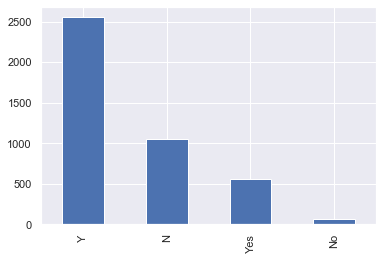

In [8]:
df['existence'].value_counts().plot.bar()

In [9]:
df['existence'] = df['existence'].replace({'Y': 'Yes', 'N': 'No'})
df = df.dropna(subset=['existence'])
#df['existence'].fillna('Ambiguous', inplace = True)

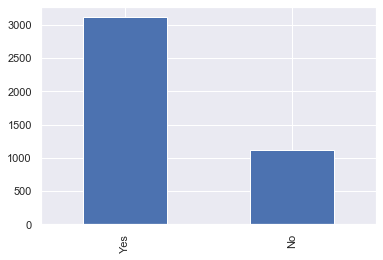

In [10]:
df['existence'].value_counts().plot.bar()

**Observation**: The data set is not balanced. Nevertheless, the analysis will proceed as is.

### Clean Tweets

Upon importing the data file into the pandas dataframe, there were some errors regarding parsing certain characters. To ensure that all tweet appear as the English language, it is necessary to remove any non-ASCII characters from the data set.

In [11]:
def clean_ascii(text):
    # Method to remove non-ASCII characters from text data
    return ''.join(i for i in text if ord(i) < 128)

In [12]:
df['tweet'] = df['tweet'].apply(clean_ascii)
df['tweet'] = df['tweet'].str.strip('[link]') # Remove '[link]'
df['tweet'] = df['tweet'].replace(r'RT+', '', regex=True) # Remove 'RT', which stands for "retweet"
df['tweet'] = df['tweet'].replace(r'@\S+', '', regex=True) # Remove twitter handles
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex = True).replace(r'www\S+', '', regex=True) # Remove websites

In [13]:
df.head()

,tweet,existence
0,Global warming report urges governments to act...,Yes
1,Fighting poverty and global warming in Africa,Yes
2,Carbon offsets: How a Vatican forest failed to...,Yes
3,Carbon offsets: How a Vatican forest failed to...,Yes
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,Yes


In [14]:
df['tweet'][5]

'    Ocean Saltiness Shows Global Warming Is Intensifying Our Water Cycle '

In [15]:
df.tail()

,tweet,existence
6084,It's 83_ and climbing in NYC. August weather f...,Yes
6085,"""The phrase 'global warming' should be abando...",Yes
6087,Global warming you tube parody you will enjoy ...,No
6088,One-Eyed Golfer: Don't dare tell me about glob...,No
6089,man made global warming a hair brained theory ...,No


Split the data into training and testing sets.

In [16]:
df_copy = df.copy()
train_df = df_copy.sample(frac = 0.8, random_state = 42)
val_df = df_copy.drop(train_df.index)

Check to make sure that the distribution of the outputs between the training and testing sets are similar.

In [17]:
train_df['existence'].value_counts()

Yes    2497
No      883
Name: existence, dtype: int64

In [18]:
val_df['existence'].value_counts()

Yes    614
No     231
Name: existence, dtype: int64

Note that ULMFit requires the dataframe structured to be labels follow by the text, respectively.

In [19]:
train = pd.concat([train_df['existence'], train_df['tweet']], axis = 1)
val = pd.concat([val_df['existence'], val_df['tweet']], axis = 1)
train.head()

,existence,tweet
2361,Yes,Putting a Price on Climate Change: The People'...
3527,Yes,Can someone please explain to conservatives ...
5662,No,Special Report: Networks Hide the Decline in C...
5962,Yes,Climate Change and the Desert USGS workshop in...
3533,Yes,"my ""side"" is science, & it's well-founded. Po..."


## Transfer Learning: Fine-tuning language model

Now comes to the part where the ULMFiT is demonstrated on the present sentiment analysis. Recall that the `WikiText-103` pre-training language model is used for fine-tuning.

### Preprocess data through `fastai.text` API

In [20]:
# For some reason, there is a memory problem in the TextClasDataBunch class.
# Had to modify the tokenizer to utilize only 1 cpu.
myTokenizer = Tokenizer(tok_func = SpacyTokenizer, n_cpus = 1)

data_lm = TextLMDataBunch.from_df('./',train_df = train, valid_df = val, 
                                tokenizer = myTokenizer, min_freq = 1)
data_lm.save()

In [21]:
data_lm.show_batch()

idx,text
0,"xxbos xxfld 1 xxmaj the xxmaj global xxmaj climate : xxmaj yes , xxmaj its xxmaj still xxmaj warming stop global warming :) xxbos xxfld 1 xxmaj there is xxmaj no xxmaj man xxmaj made xxmaj climate xxmaj crisis ( xxmaj global xxmaj warming is a xxmaj hoax ) global warming xxup :o xxbos xxfld 1 xxmaj report : xxmaj save the xxmaj whales and xxmaj they 'll xxmaj save"
1,"news : xxmaj right - wingers already claiming that the blizzard proves climate change ... ( via xxbos xxfld 1 xxmaj water at core of climate change impacts xxup ^ab xxbos xxfld 1 xxup qut researchers track climate change xxbos xxfld 1 - xxmaj xxunk view of the near record show storm over xxmaj washington xxup dc . "" xxmaj global warming "" ? ? xxmaj ha xxmaj ha !"
2,"xxmaj well so much for this whole ' global warming ' thing . "" xxmaj idiots . xxmaj great article . demint , you 're a tool . xxbos xxfld 1 xxup epa ca n't finish their report on xxmaj global xxmaj warming because it was there is too much snow to go to work . xxbos xxfld 1 just saw someone post on xxup fb that # snowpocalypse must"
3,"hint :) xxbos xxfld 1 xxmaj when i see a warning for xxup another 10 - 20 "" of snow i wish xxunk still used 3 xxunk of xxunk per day to speed up the global warming process xxbos xxfld 1 xxmaj top xxup u.s. xxmaj vacation spots becoming endangered . xxmaj landscape threatened by global warming , mining , weather , environmental hazard & populatio xxbos xxfld 1 xxmaj"
4,has become our best early - warning system for the effects of global warming . xxbos xxfld 1 xxunk to xxmaj lindsay xxmaj graham on being so strong on climate change . xxbos xxfld 1 xxmaj tea - party xxunk now xxunk on xxunk xxmaj california 's global - warming law : xxbos xxfld 1 xxmaj climate xxmaj change xxmaj impacts xxmaj and xxmaj vulnerability xxmaj in xxmaj the xxmaj


**Observation**: The above is an example that shows the tokenization technique used by `fastai.text` which involves some advanced technqiues to capture semantic meaning from the text. Details of the tokenization rules can be found [here](https://docs.fast.ai/text.transform.html).

### Define learning object for NLP model

In [22]:
learn = language_model_learner(data = data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.5)

C:\Users\Anthony\Anaconda3\lib\site-packages\fastai\datasets.py:75: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


### Get an idea on the optimum learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Wall time: 13.6 s


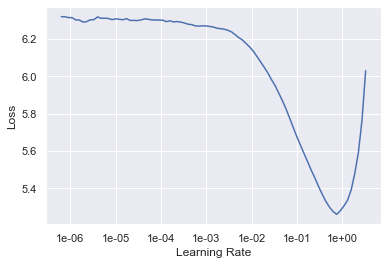

In [23]:
%%time
learn.lr_find()
learn.recorder.plot()

**Observation**: The lowest point of the curve occurs about 1e+0. Note that the learning rate finder will increase the learning rate after each mini-batch. As shown in the plot, eventually too high of a learning rate results to a higher loss. Therefore, choose a learning rate that is about 1 order of magnitude smaller than the optimal value. Start with 1e-1.

### Discriminative fine-tuning

According to Howard and Ruder [[1](https://arxiv.org/abs/1801.06146)], it was found empirically that discriminative fine-tuning on the LM works well by first fine-tuning only the last layer with some learning rate $\eta^{L}$ and then fine-tune the lower $l$ layers by using $\eta^{l-1}=\eta^{l}/2.6$ as the learning rate. 

#### Fine-tune the last layer

In [24]:
%%time
learn.freeze()
learn.fit_one_cycle(cyc_len = 1, max_lr = 1e-1, moms = (0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,4.395796,3.240959,0.420020


Wall time: 2.88 s


#### Fine-tune the lower layers

Here, set the cycle length no more than 5 since it was observed that the model begins to overfit beyond that point.

In [25]:
%%time
learn.unfreeze()
learn.fit_one_cycle(cyc_len = 1, max_lr = 1e-2, moms = (0.9, 0.8))

epoch,train_loss,valid_loss,accuracy
1,3.161202,2.896106,0.466291


Wall time: 3.89 s


In [26]:
# Save the fine-tuned encoder to be used later for fine-tuning the classifier
learn.save_encoder('ft_enc')

In [27]:
# Show sample results
learn.show_results()

text,target,pred
xxbos xxfld 1 xxmaj fighting poverty and global warming in xxmaj africa xxbos xxfld 1 xxup uruguay : xxmaj tools,needed for xxmaj those xxmaj most xxmaj vulnerable to xxmaj climate xxmaj change xxbos xxfld 1 xxmaj global warming to,needed for xxmaj global xxmaj most xxmaj vulnerable to xxmaj climate xxmaj change : xxfld 1 xxmaj global xxmaj is
xxfld 1 xxmaj even the generals know climate change is going to screw us . xxbos xxfld 1 xxmaj climate,"increases heat waves , floods : xxup epa xxbos xxfld 1 xxmaj climate change melts two xxunk , xxmaj xxunk","is heat waves , floods : xxmaj epa xxmaj xxfld 1 xxmaj global change is in more of xxmaj xxunk"
the world 's .. xxbos xxfld 1 xxmaj african xxmaj xxunk xxmaj services xxmaj xxunk xxmaj up for xxmaj climate,change . ( xxunk ) # xxup xxunk xxbos xxfld 1 xxmaj report : xxmaj allergy xxmaj season to xxmaj,change : xxmaj via ) xxbos tcot gop xxbos xxfld 1 xxmaj global : xxmaj global xxmaj season to xxmaj
: xxmaj time xxmaj xxunk xxmaj xxunk xxmaj africa : xxup there is no doubt that climate change as an,issue ha ... xxbos xxfld 1 xxmaj seasonal xxmaj allergies xxmaj getting xxmaj worse xxmaj from xxmaj climate xxmaj change,conspiracy of ... xxbos xxfld 1 xxmaj global xxmaj allergies xxmaj worse xxmaj worse xxmaj with xxmaj climate xxmaj change
xxmaj perceptions : xxmaj the effects of climate change - such as drought ... xxbos xxfld 1 xxmaj leaked xxup,xxmaj document xxmaj calls xxmaj for _ xxmaj global xxmaj regime _ xxmaj to xxmaj tackle xxmaj climate xxmaj change,xxmaj climate xxmaj calls xxmaj for xxmaj xxmaj climate xxmaj warming xxmaj xxmaj xxunk xxmaj combat xxmaj climate xxmaj change


## Transfer learning: Fine-tune classifier for global warming sentiment tweets

In [28]:
data_clas = TextClasDataBunch.from_df('./',train_df = train, valid_df = val,
                                     tokenizer = myTokenizer, vocab = data_lm.train_ds.vocab, 
                                            min_freq = 1, bs =32)
data_clas.save()

In [29]:
data_clas.show_batch()

text,target
"xxbos xxfld 1 xxup for xxup all xxup you xxup xxunk xxup that xxup xxunk xxup in xxup al xxup gore xxup 's xxup global xxup warming xxup scam , i xxup think xxup its xxup time xxup to xxup kick xxup his xxup ass xxup and xxup get xxup your xxup money xxup back .",No
"xxbos xxfld 1 xxmaj dear xxmaj stupid xxmaj people xxmaj who xxmaj think xxmaj these xxmaj winter xxmaj storms xxmaj means xxmaj there 's xxmaj no xxmaj such xxmaj thing xxmaj as xxmaj global xxmaj warming , xxmaj you 're stupid . xxmaj love , xxmaj shut up",Yes
"xxbos xxfld 1 xxmaj dear xxmaj stupid xxmaj people xxmaj who xxmaj think xxmaj these xxmaj winter xxmaj storms xxmaj means xxmaj there 's xxmaj no xxmaj such xxmaj thing xxmaj as xxmaj global xxmaj warming , xxmaj you 're stupid . xxmaj love , xxmaj shut up",Yes
"xxbos xxfld 1 xxmaj lisa p xxmaj jackson , xxup epa , s xxmaj most xxmaj ignorant xxup black xxup woman xxunk xxmaj xxunk xxmaj obama , seen in long time ! xxmaj global xxmaj warming has xxmaj been xxup xxunk xxup stupid ' xxup xxunk !",No
xxbos xxfld 1 xxmaj xxunk xxmaj xxunk and xxmaj dem xxmaj now is heading to xxmaj bolivia for the xxmaj world xxmaj people 's xxmaj conference on xxmaj climate xxmaj change . xxmaj tune in xxmaj next xxmaj week . # xxup wpccc # xxmaj cochabamba,Yes


Below are two methods where a customized cross entropy loss and accuracy metric are defined. For some reason, this version of `fastai` asserts that the target data to be fed in the `text_classifier_learner` needs to be of type `long` float. The two customized methods below is one solution to alleviate this issue.

In [30]:
class MyCrossEntropy(nn.CrossEntropyLoss):
  
  def forward(self, input, target):
    target = target.long()  # ADDED
    return F.cross_entropy(input, target, weight=self.weight, ignore_index=self.ignore_index, reduction=self.reduction)

In [31]:
def MyAccuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    '''Compute accuracy with targs when input is bs * n_classes.'''
    targs = targs.view(-1).long() # ADDED
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

In [32]:
learn = text_classifier_learner(data = data_clas,loss_func = MyCrossEntropy(), drop_mult = 0.7
                                , metrics = [MyAccuracy])
learn.load_encoder('ft_enc')
learn.freeze()

### Training by gradual unfreezing layers of the neural network

First determine optimal learning rate for the classifier

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


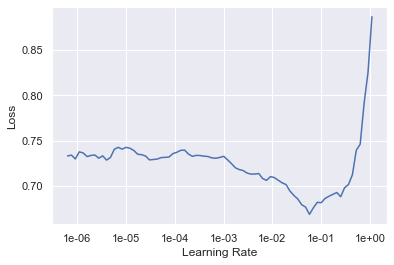

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
%%time
learn.fit_one_cycle(cyc_len=1, max_lr=1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,MyAccuracy
1,0.538341,0.491120,0.752663


Wall time: 10.9 s


In [35]:
%%time
learn.freeze_to(-2)
learn.fit_one_cycle(1, max_lr = slice(1e-2/2.6,1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,MyAccuracy
1,0.496364,0.457814,0.775148


Wall time: 14 s


In [36]:
%%time
learn.freeze_to(-3)
learn.fit_one_cycle(1, max_lr = slice(5e-3/(2.6**2),5e-3), moms=(0.7, 0.6))

epoch,train_loss,valid_loss,MyAccuracy
1,0.479011,0.457635,0.763314


Wall time: 16.2 s


In [37]:
%%time
learn.unfreeze()
learn.fit_one_cycle(2, max_lr = slice(1e-3/(2.6**3),1e-3), moms=(0.7, 0.6))

epoch,train_loss,valid_loss,MyAccuracy
1,0.436890,0.436260,0.797633
2,0.428731,0.433173,0.792899


Wall time: 40.7 s


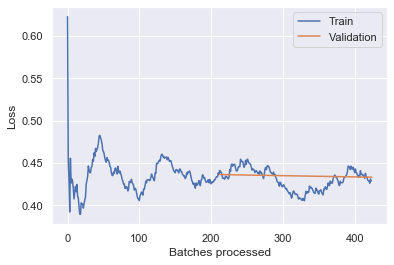

In [38]:
learn.recorder.plot_losses()

**Observations**: Some overfitting can be seen shortly after 2 epochs in the above training. The level of accuracy achieved through this gradual unfreezing process should be noteworthy. The utilization of the GPU certainly helped these process tremendously.

In [39]:
# See some results
learn.show_results()

text,target,prediction
xxbos xxfld 1 xxmaj another xxmaj snowstorm : xxmaj what xxmaj happened to xxmaj global xxmaj warming ? xxmaj round 2 : xxmaj blizzards hit xxmaj mid - xxmaj atlantic to xxmaj new xxmaj york ... xxmaj who xxmaj would xxmaj xxunk xxmaj governor xxmaj pat ...,Yes,Yes
"xxbos xxfld 1 xxmaj snow ? xxmaj global xxmaj warming ? xxmaj natural xxmaj laws & xxmaj climate xxmaj change : xxmaj sun xxmaj xxunk xxmaj new ... : xxup law xxup xxunk xxmaj sunday , xxmaj february xxunk , 2010 2 / xxunk / ...",Yes,Yes
"xxbos xxfld 1 xxmaj climate xxmaj denial xxmaj crock of the xxmaj week : "" xxmaj it 's cold . xxmaj so there 's no xxmaj climate xxmaj change "" : xxmaj with xxmaj washington , ... # climate # xxup wwfus # xxup wwf",Yes,Yes
"xxbos xxfld 1 17 . xxmaj xxunk xxunk - do we have the rt . to do this ? xxmaj xxunk : xxunk - xxunk has a xxup lot xxup of xxup risks ( then again , so does runaway climate change ) . :(",Yes,Yes
xxbos xxfld 1 xxmaj is xxmaj global xxmaj warming xxmaj the xxmaj xxunk xxmaj lie xxmaj ever xxmaj xxunk : xxmaj xxunk xxmaj home xxmaj smart : xxmaj author : xxmaj xxunk xxmaj xxunk xxmaj xxunk : xxmaj is xxmaj global xxmaj warming t ...,No,Yes


## Classification evaluation

In [40]:
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis = 1)

In [41]:
from sklearn.metrics import classification_report, confusion_matrix


 CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

          NO       0.66      0.51      0.57       231
         YES       0.83      0.90      0.86       614

   micro avg       0.79      0.79      0.79       845
   macro avg       0.74      0.70      0.72       845
weighted avg       0.78      0.79      0.78       845



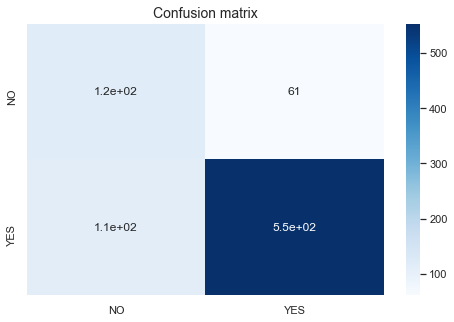

In [42]:
class_names = ['NO', 'YES'] # Note the class names are labeled in alphabetical order in fastai.text
print('\n CLASSIFICATION REPORT: \n', classification_report(targets, predictions, target_names=class_names), sep='') 

# Confusion matrix
plt.figure(figsize=(8,5))
sns.set(font_scale=1)
cm = confusion_matrix(predictions, targets)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, cmap='Blues', annot = True, 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion matrix', fontsize=14)
plt.show()

**Observations**: From the confusion table, it can be seen that the model predicts positive sentiment (i.e., 'Yes') pretty well with a F1-score of 0.86 while predictions on negative sentiment (i.e., 'No') has a lower F1-score of 0.57. Possible reasons could be the imbalance distribution of tweets and that the language syntax of tweets can be quite different from the WikiText-103 corpus that the present model is trained on. One could use the Twitter Sentiment140 dataset available in Kaggle to fine-tune the language model. Do note that the Twitter Sentiment140 dataset does contain about 1 million tweets and so one needs to find a feasible subsample that can capture as many possible nuances as possible for the language model.

## Conclusions

This notebook demonstrated the use of the ULMFiT model for transfer learning on global warming sentiment tweets. The approach to the ULMFiT model can be implemented using the `fastai` API. When taking advantage of the CUDA, NLP training can be done relatively quickly with good accuracy compared to vanilla methods like the Keras API with TensorFlow backend. One improvement that may be worth trying is using domain-specific data like a large Twitter Sentiment corpus to capture the language syntax found in tweets. Other improvements such as fine-tuning the learning rates but given that the model can be easily overfitted, there is very little room to seek for better rates.